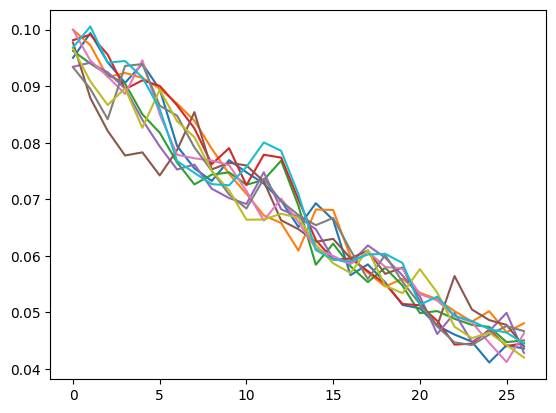

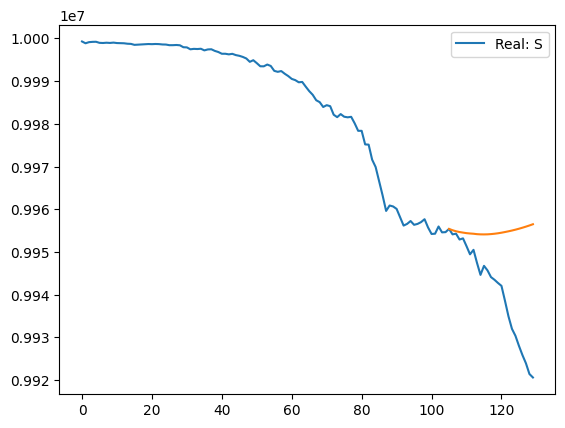

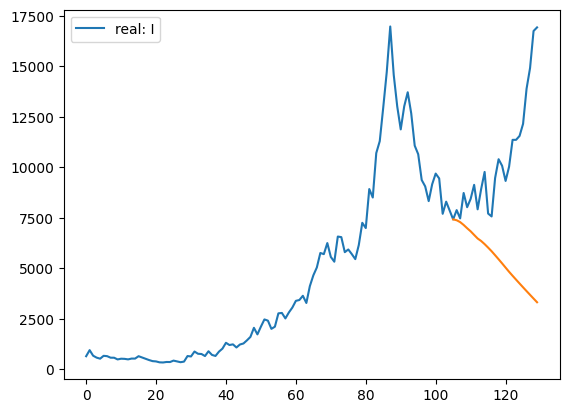

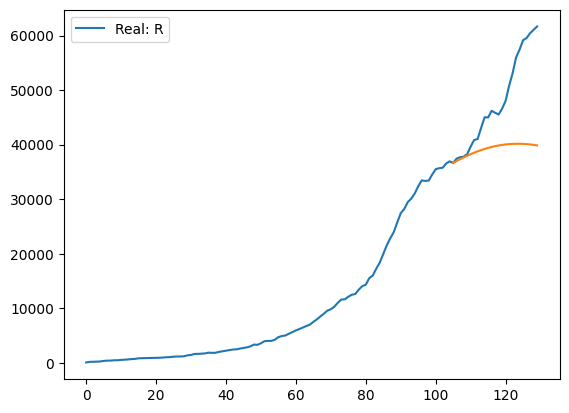

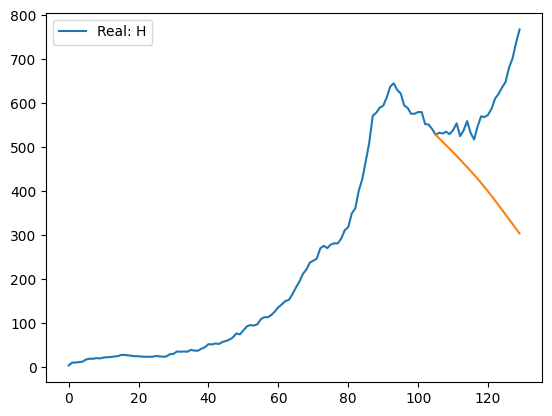

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


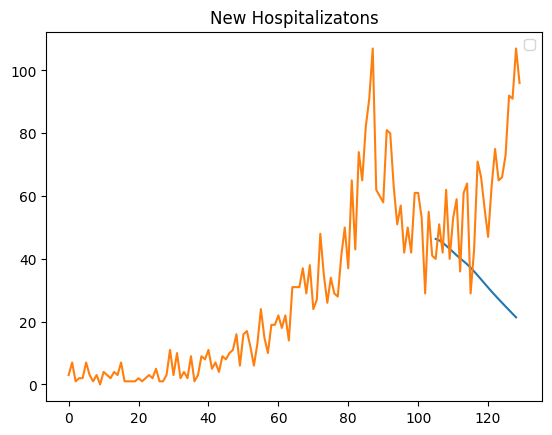

In [59]:
import numpy as np
from scipy.stats import nbinom
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import pandas as pd


'''Read in the necessary csv files'''

state_name = "MI"

predicted_beta = pd.read_csv('../datasets/Out_prog3/out_logit-beta_trj_rnorm.csv').to_numpy()
predicted_beta = np.delete(predicted_beta,0,1)

observations = pd.read_csv(f'../datasets/{state_name}_FLU_HOSPITALIZATIONS.csv').to_numpy()
observations = np.delete(observations,0,1)

estimated_state = pd.read_csv('../datasets/ESTIMATED_STATE.csv').to_numpy()
estimated_state = np.delete(estimated_state,0,1)

pf_beta = pd.read_csv('../datasets/average_beta.csv').to_numpy()
pf_beta = np.delete(pf_beta,0,1).squeeze()


endpoint = 105

'''Setup the time span up to the final data point and the forecast'''
t_span = [0,endpoint]
forecast_span = [endpoint,endpoint+25]


'''Plots the beta estimate from Jaechouls code '''
for i in range(10):
    plt.plot(predicted_beta[i,:])
plt.show()

'''Model definition for the integrator'''

def RHS_H(t,state,param):
    #params has all the parameters – beta, gamma
    #state is a numpy array

        S,I,R,H,new_H = state #unpack the state variables
        N = S + I + R + H #compute the total population 

        new_H = (1/param['D'])*(param['gamma']) * I

        '''The state transitions of the ODE model is below'''
        dS = -param['beta'](int(t))*(S*I)/N + (1/param['L'])*R 
        dI = param['beta'](int(t))*S*I/N-(1/param['D'])*I
        dR = (1/param['hosp']) * H + ((1/param['D'])*(1-(param['gamma']))*I)-(1/param['L'])*R 
        dH = (1/param['D'])*(param['gamma']) * I - (1/param['hosp']) * H 

        return np.array([dS,dI,dR,dH,new_H])

'''Functional form of beta to use for integration'''

def beta(t):  
    if(t < t_span[1]): 
        return pf_beta[t]
    else:
        return predicted_beta[5,t-forecast_span[0]]

par={
"beta":beta,
"gamma":0.06,
"hosp":10,
"L":90,
"D":10}

'''Solve the system through the forecast time'''
forecast = solve_ivp(fun=lambda t,z: RHS_H(t,z,par), 
                        t_span=[forecast_span[0],forecast_span[1]],
                        y0=np.concatenate((estimated_state[forecast_span[0]],observations[forecast_span[0]])),
                        t_eval = np.linspace(forecast_span[0],forecast_span[1],forecast_span[1] - forecast_span[0]),
                        method='RK45').y


'''Plotting'''

labels = ['Real: S','real: I','Real: R','Real: H']
for i in range(4):
    plt.plot(estimated_state[t_span[0]:forecast_span[1],i],label = labels[i])
    plt.plot(np.arange(forecast_span[0],forecast_span[1]),forecast[i,:])
    plt.legend()
    plt.show()


plt.title("New Hospitalizatons")
plt.plot(np.arange(forecast_span[0],forecast_span[1]-1),np.diff(forecast[4,:]))
plt.plot(observations[t_span[0]:forecast_span[1]])
plt.legend()




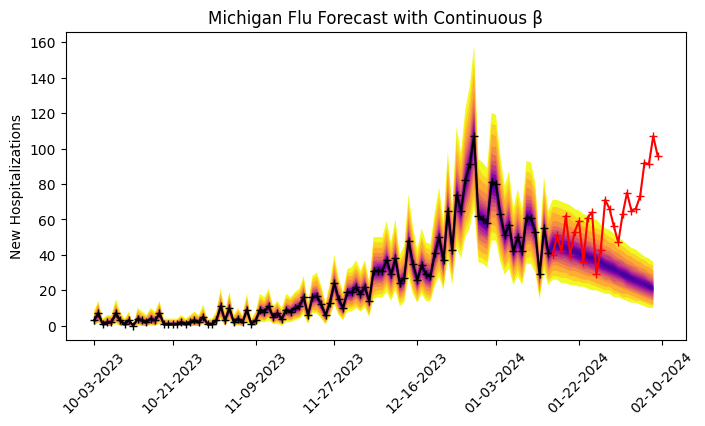

In [60]:
import numpy as np
from scipy.stats import nbinom
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import pandas as pd
from matplotlib import cm
from datetime import datetime,timedelta


'''This code generates a distribution over the observed and forecasted '''

forecast_newH = np.diff(forecast[4,:])

timeseries = np.copy(np.concatenate((observations[:t_span[1]].squeeze(),forecast_newH)))

num_rv = 10000

output = np.zeros((num_rv,len(timeseries)))

r = 40

r=np.ceil(r) 

for i in range(len(timeseries)):  
    output[:,i] = nbinom.rvs(n=r, p=r/(r+timeseries[i]), size=num_rv)

quantiles_hosp = []
def quantiles(items):
        '''Returns 23 quantiles of the List passed in'''
        qtlMark = 1.00*np.array([0.010, 0.025, 0.050, 0.100, 0.150, 0.200, 0.250, 0.300, 0.350, 0.400, 0.450, 0.500, 0.550, 0.600, 0.650, 0.700, 0.750, 0.800, 0.850, 0.900, 0.950, 0.975, 0.990])
        return list(np.quantile(items, qtlMark))

for i in range(len(timeseries)):
    quantiles_hosp.append(quantiles(output[:,i]))

quantiles_hosp = np.array(quantiles_hosp)


d1 = datetime.strptime('2023-10-3', "%Y-%m-%d")

x_interval=np.linspace(0,forecast_span[1],8)

x_interval_int=x_interval.astype('int64')

x_interval_int=x_interval_int.astype(float)

 

date_strings=[]

for d_ind in range(len(x_interval)):

    this_d=d1+timedelta(days=x_interval_int[d_ind])

    date_strings.append(this_d.strftime("%m-%d-%Y"))

fig = plt.figure(figsize=(8,4))
plt.ylabel('New Hospitalizations')
plt.title("Michigan Flu Forecast with Continuous β")
plt.xticks(x_interval_int,date_strings,rotation=45)
colors = cm.plasma(np.linspace(0, 1, 12)) # type: ignore

for i in range(11):
    plt.fill_between(np.arange(t_span[0],forecast_span[1]-1), quantiles_hosp[:, i], quantiles_hosp[:,22-i], facecolor=colors[11 - i], zorder=i)


plt.plot(observations[t_span[0]:t_span[1]],zorder = 13,marker = '+',color='black')
plt.plot(np.arange(forecast_span[0],forecast_span[1]),observations[forecast_span[0]:forecast_span[1]],zorder = 14,marker = '+',color='red')
plt.savefig(f'{state_name}_UQ.png') 




